In [1]:
!pip install kagglehub
!pip install opencv-python scikit-image matplotlib

In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("ipateam/nuinsseg")
print("Dataset downloaded at = ", dataset_path)

100%|██████████| 1.52G/1.52G [00:51<00:00, 31.3MB/s]

Extracting files...


Dataset downloaded at =  /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

Inside tissue folder = 
['label masks', 'weighted_maps_erode', 'overlay_save_path', 'tissue images', 'mask binary without border', 'vague areas', 'stacked mask', 'Imagj_zips', 'mask binary', 'distance maps', 'nuclei border', 'label masks modify', 'mask binary without border erode', 'weighted_maps']
Image folder =  /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/human kidney/tissue images
Mask folder =  /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/human kidney/mask binary without border erode
Total images found =  11


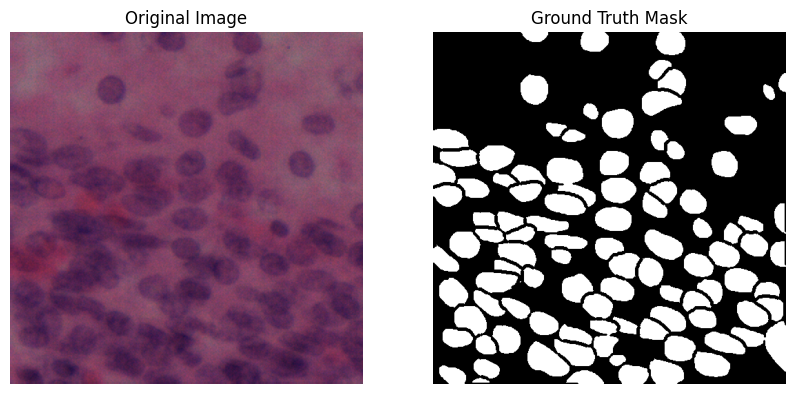

In [4]:
tissue_folder_path = os.path.join(dataset_path, "human kidney")
print("Inside tissue folder = ")
print(os.listdir(tissue_folder_path))

subfolder_list = os.listdir(tissue_folder_path)
image_folder_path = None
mask_folder_path = None

for subfolder_name in subfolder_list:
    if "image" in subfolder_name.lower():
        image_folder_path = os.path.join(tissue_folder_path, subfolder_name)
    if "mask" in subfolder_name.lower() or "label" in subfolder_name.lower():
        mask_folder_path = os.path.join(tissue_folder_path, subfolder_name)

print("Image folder = ", image_folder_path)
print("Mask folder = ", mask_folder_path)

image_file_list = sorted(os.listdir(image_folder_path))
mask_file_list = sorted(os.listdir(mask_folder_path))

print("Total images found = ", len(image_file_list))

original_image = cv2.imread(os.path.join(image_folder_path, image_file_list[0]))
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

ground_truth_mask = cv2.imread(os.path.join(mask_folder_path, mask_file_list[0]), 0)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ground_truth_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.show()

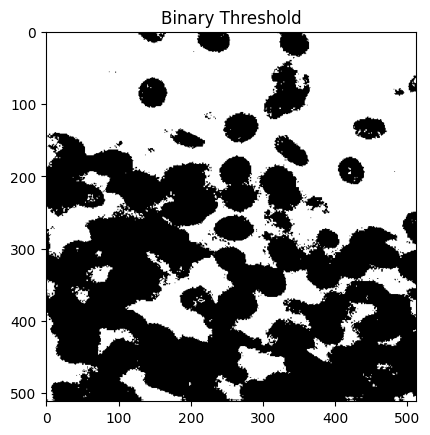

In [5]:
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
_, binary_threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(binary_threshold, cmap='gray')
plt.title("Binary Threshold")
plt.show()

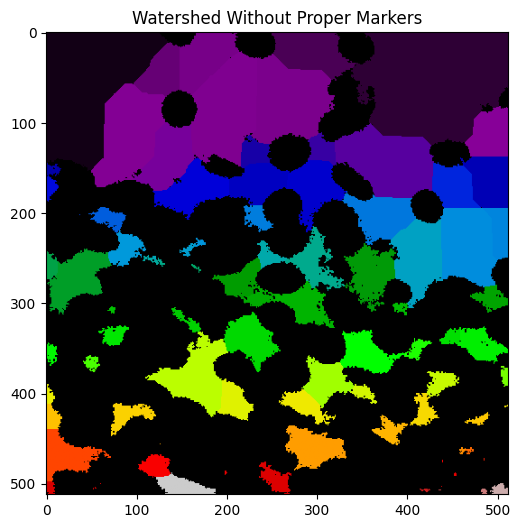

In [6]:
distance_map = ndimage.distance_transform_edt(binary_threshold)
local_max_coordinates = peak_local_max(distance_map, footprint=np.ones((25, 25)), labels=binary_threshold)

local_peak_mask = np.zeros(distance_map.shape, dtype=bool)
local_peak_mask[tuple(local_max_coordinates.T)] = True

initial_markers = measure.label(local_peak_mask)
labels_without_markers = watershed(-distance_map, initial_markers, mask=binary_threshold)

plt.figure(figsize=(6,6))
plt.imshow(labels_without_markers, cmap='nipy_spectral')
plt.title("Watershed Without Proper Markers")
plt.show()

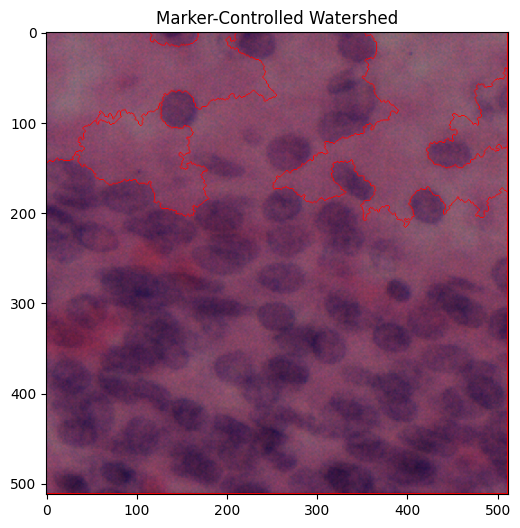

In [7]:
structuring_kernel = np.ones((3,3), np.uint8)
opening_result = cv2.morphologyEx(binary_threshold, cv2.MORPH_OPEN, structuring_kernel, iterations=2)

sure_background = cv2.dilate(opening_result, structuring_kernel, iterations=3)
distance_transform_map = cv2.distanceTransform(opening_result, cv2.DIST_L2, 5)

ret_value, sure_foreground = cv2.threshold(distance_transform_map, 0.5 * distance_transform_map.max(), 255, 0)
sure_foreground = np.uint8(sure_foreground)

unknown_region = cv2.subtract(sure_background, sure_foreground)
ret_value, connected_markers = cv2.connectedComponents(sure_foreground)

connected_markers = connected_markers + 1
connected_markers[unknown_region == 255] = 0

image_copy = original_image.copy()
connected_markers = cv2.watershed(image_copy, connected_markers)

image_copy[connected_markers == -1] = [255, 0, 0]

plt.figure(figsize=(6,6))
plt.imshow(image_copy)
plt.title("Marker-Controlled Watershed")
plt.show()

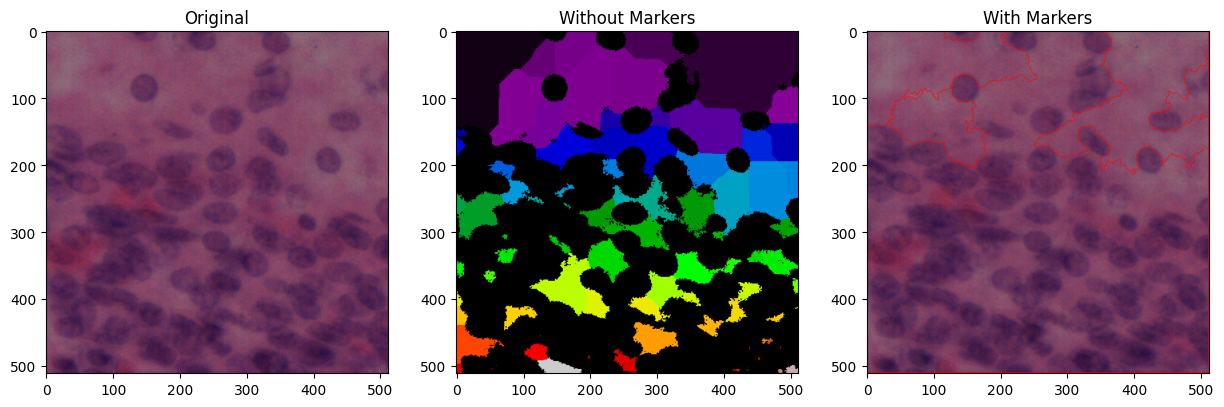

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(original_image)
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(labels_without_markers, cmap='nipy_spectral')
plt.title("Without Markers")

plt.subplot(1,3,3)
plt.imshow(image_copy)
plt.title("With Markers")

plt.show()

In [9]:
print("Objects without markers = ",
      len(np.unique(labels_without_markers)))

print("Objects with markers = ",
      len(np.unique(connected_markers)))

Objects without markers =  93
Objects with markers =  6
